# Create and manipulate graphs

In [1]:
import graph_tool.all as gt
import numpy as np
import scipy.sparse

import matplotlib.pyplot as plt

## A simple example to create a weighted graph

We first create an empty graph object as follows. 

In [2]:
g = gt.Graph(directed=True)

This line creates a directed graph. If you want a directed graph (like a citation network or web graph), use `directed=False`. We then create an edge property map for weights. 

In [3]:
edge_weight = g.new_edge_property("int")

In [4]:
vertex_label = g.new_vertex_property("string")

What is a property map?
A property map in graph-tool is a data structure that attaches additional information to each element of the graph — such as a label, a category, or, in our case, a numeric weight.
Here, "int" means the values are floating-point numbers (like 2 or 3), which are perfect for edge weights. 

This line prepares the graph to store a weight value for every edge we’ll add later.

We then add some vertices in the graph. 

In [5]:
v0 = g.add_vertex()
vertex_label[v0] = "v0"

v1 = g.add_vertex()
vertex_label[v1] = "v1"

v2 = g.add_vertex()
vertex_label[v2] = "v2"

v3 = g.add_vertex()
vertex_label[v3] = "v3"

Each call to `add_vertex()` creates one new vertex. We store them in variables (v0, v1, etc.) so we can refer to them when adding edges.

Now let’s connect these vertices with edges and assign a numeric weight to each edge.

In [6]:
e01 = g.add_edge(v0, v1)
edge_weight[e01] = 2

e12 = g.add_edge(v1, v2)
edge_weight[e12] = 1

e23 = g.add_edge(v2, v3)
edge_weight[e23] = 3

e30 = g.add_edge(v3, v0)
edge_weight[e30] = 4


Here:

- add_edge(v0, v1) connects two vertices.
- edge_weight[e] = ... assigns a weight to that specific edge using our property map.

We then attach the edge_weight property map to the graph under the key "weight". This makes it easy to access later (for example, during saving, loading, or running graph algorithms).

In [7]:
g.edge_properties["weight"] = edge_weight
g.vertex_properties["label"] = vertex_label

/nb/yuanming/miniconda3/envs/gt/lib/python3.13/site-packages/graph_tool/draw/cairo_draw.py:545: UserWarning: Unknown edge attribute: text_rotation
  warnings.warn(f"Unknown {kind} attribute: " + str(k), UserWarning)


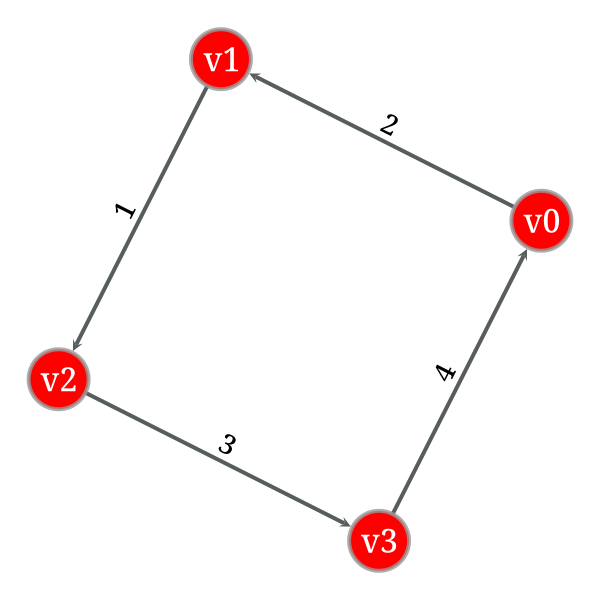

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f3229465be0, at 0x7f322705bdd0>

In [8]:
gt.graph_draw(
    g,
    vertex_text=vertex_label,      # show node names
    edge_text=edge_weight,          # show edge weights
    vertex_font_size=16,
    edge_font_size=14,
    vertex_fill_color="red",
    vertex_size=30,
    vertex_pen_width=2,
    edge_pen_width=2,
    edge_text_rotation=False,
    bg_color=[1, 1, 1, 1],
    output_size=(300, 300)
)

This draws the graph and saves it to weighted_graph.png. The edge weights will appear as labels along the edges.

You must have Cairo installed to save to PNG or PDF.

In summary, `gt.Graph` is a general multigraph class. This class encapsulates either a directed multigraph (default or if directed == True) or an undirected multigraph (if directed == False), with optional internal edge, vertex or graph properties.

## More ways to create graphs

Graph objects do not have to be built up incrementally - data specifying graph structure can be passed directly to the constructors of the various graph classes. When creating a graph structure by instantiating one of the graph classes you can specify data in several formats.

`graph-tool`'s `Graph` object has an `add_edge_list()` method that lets you efficiently add multiple edges from a list or NumPy array. 

Suppose that we have the following directed graph: 

<img src="../figures/tikz_network.png" alt="Simple Network" width="300"/>   

### Edge list

An [edge list](https://en.wikipedia.org/wiki/Edge_list) is a data structure used to represent a graph as a list of its edges. In Python, an iterable over (source, target, weights) pairs can be used to populate the graph. 

/nb/yuanming/miniconda3/envs/gt/lib/python3.13/site-packages/graph_tool/draw/cairo_draw.py:545: UserWarning: Unknown edge attribute: marker
  warnings.warn(f"Unknown {kind} attribute: " + str(k), UserWarning)


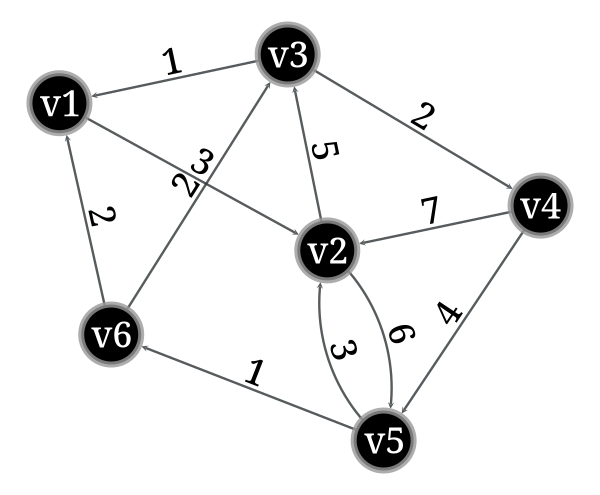

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f322a35b9d0, at 0x7f3227076580>

In [10]:
# edge list 
elist = [
    (0, 1, 3),  # v1 → v2
    (1, 2, 5),  # v2 → v3
    (2, 3, 2),  # v3 → v4
    (3, 4, 4),  # v4 → v5
    (4, 5, 1),  # v5 → v6
    (5, 0, 2),  # v6 → v1
    (1, 4, 6),  # v2 → v5
    (2, 0, 1),  # v3 → v1
    (4, 1, 3),  # v5 → v2
    (3, 1, 7),  # v4 → v2
    (5, 2, 2),  # v6 → v3
]


# Create directed graph
g = gt.Graph(directed=True)

# # Add 6 vertices
# g.add_vertex(6)

# Create edge property for weight
weight = g.new_edge_property("int")

# Add edges with weights
g.add_edge_list(elist, eprops=[weight])
g.edge_properties["weight"] = weight

# Add vertex labels (v1 to v6)
label_prop = g.new_vertex_property("string")
for i, label in enumerate(["v1", "v2", "v3", "v4", "v5", "v6"]):
    label_prop[g.vertex(i)] = label
g.vertex_properties["label"] = label_prop

# Draw the graph
gt.graph_draw(
    g,
    vertex_text=label_prop,
    edge_text=weight,
    vertex_fill_color=[0, 0, 0, 1],
    vertex_font_color=[1, 1, 1, 1],
    vertex_size=30,
    edge_pen_width=1.2,
    edge_arrow_size=15,  # Make arrows clearly visible
    edge_marker="arrow", # Ensure directed arrows
    output_size=(300, 300)
)

### Adjacency list

An [adjacency list](https://en.wikipedia.org/wiki/Adjacency_list), i.e. a dictionary with vertex keys mapping to an interable of vertices, which will be used to populate the graph. In our case, the dictionary looks like `{source: [(target, weight)]}`. 

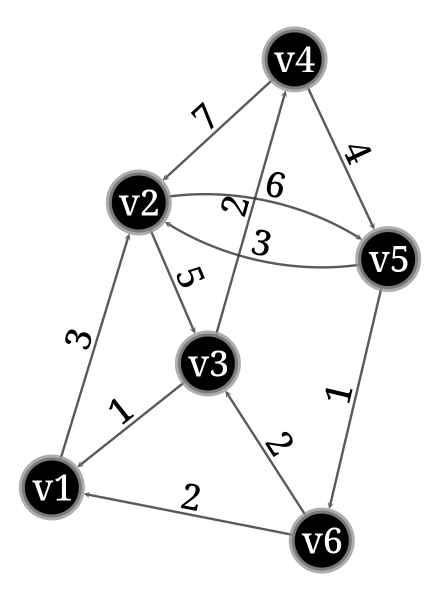

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f322a37f100, at 0x7f3227076740>

In [12]:
import graph_tool.all as gt

# Step 1: Define the adjacency list
adj_list = {
    0: [(1, 3)],
    1: [(2, 5), (4, 6)],
    2: [(3, 2), (0, 1)],
    3: [(4, 4), (1, 7)],
    4: [(5, 1), (1, 3)],
    5: [(0, 2), (2, 2)]
}

# Step 2: Convert to edge list generator
def edge_generator():
    for src, targets in adj_list.items():
        for tgt, weight in targets:
            yield src, tgt, weight

# Step 3: Create graph
g = gt.Graph(directed=True)
g.add_vertex(6)  # total 6 nodes

# Step 4: Define edge property for weights
weight = g.new_edge_property("int")
g.add_edge_list(edge_generator(), eprops=[weight])
g.edge_properties["weight"] = weight

# Step 5: Add vertex labels (v1 to v6)
label_prop = g.new_vertex_property("string")
for i in range(6):
    label_prop[g.vertex(i)] = f"v{i+1}"
g.vertex_properties["label"] = label_prop

# Step 6: Draw the graph
gt.graph_draw(
    g,
    vertex_text=label_prop,
    edge_text=weight,
    vertex_fill_color=[0, 0, 0, 1],
    vertex_font_color=[1, 1, 1, 1],
    vertex_size=30,
    edge_pen_width=1.2,
    edge_arrow_size=15,
    edge_marker="arrow",
    output_size=(300, 300)
)


### Sparse Matrix

/nb/yuanming/miniconda3/envs/gt/lib/python3.13/site-packages/graph_tool/draw/cairo_draw.py:545: UserWarning: Unknown edge attribute: font_color
  warnings.warn(f"Unknown {kind} attribute: " + str(k), UserWarning)
/nb/yuanming/miniconda3/envs/gt/lib/python3.13/site-packages/graph_tool/draw/cairo_draw.py:545: UserWarning: Unknown edge attribute: arrow_size
  warnings.warn(f"Unknown {kind} attribute: " + str(k), UserWarning)


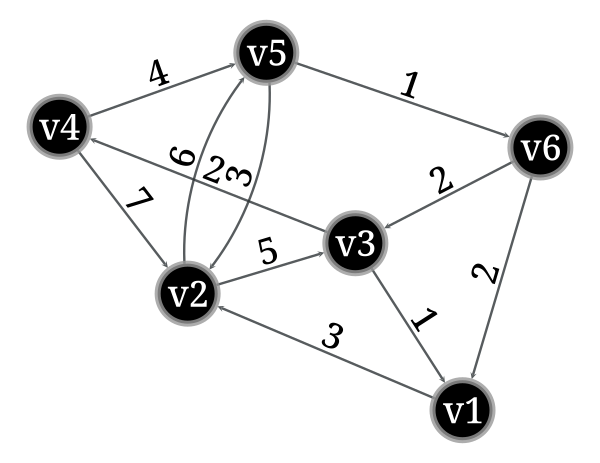

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f323ddb0350, at 0x7f3227077000>

In [17]:
# Create a 6x6 sparse adjacency matrix (weight=1 if edge exists)
adj_matrix = np.array( [[0, 3, 0, 0, 0, 0], 
                        [0, 0, 5, 0, 6, 0], 
                        [1, 0, 0, 2, 0, 0], 
                        [0, 7, 0, 0, 4, 0], 
                        [0, 3, 0, 0, 0, 1], 
                        [2, 0, 2, 0, 0, 0]], 
                      dtype=np.int32)

# Convert to sparse COO matrix
a = scipy.sparse.coo_array(adj_matrix)

# Extract row (source), col (target), data (weight)
s, t, w = scipy.sparse.find(a)

# Combine into edge list with weights
es = np.array([s, t, w]).T  # shape: (num_edges, 3)

# Create directed graph and add edges with weights
g = gt.Graph(directed=True)

g.add_vertex(a.shape[0])
weight = g.new_edge_property("int")
g.add_edge_list(es, eprops=[weight])
g.edge_properties["weight"] = weight

# Add vertex labels
label_prop = g.new_vertex_property("string")
for i in range(6):
    label_prop[g.vertex(i)] = f"v{i+1}"

# Draw the graph
gt.graph_draw(
    g,
    vertex_text=label_prop,
    edge_text=weight,
    vertex_fill_color=[0, 0, 0, 1],
    vertex_font_color=[1, 1, 1, 1],
    vertex_size=30,
    edge_pen_width=1.2,
    edge_arrow_size=10,
    output_size=(300, 300)
)


Edge lists, adjacency lists, and adjacency matrices are all ways to represent graphs.
- **Edge List**: A list of edges, where each edge is represented as a tuple of (source, target, weight).
- **Adjacency List**: A dictionary where each key is a node and the value is a list of tuples representing the target node and weight.
- **Adjacency Matrix**: A 2D array where the element at (i, j) represents the weight of the edge from node i to node j. If there is no edge, the value is typically 0 or infinity. 

### Graph I/O (saving and loading graph)

Graph I/O in graph-tool allows for saving and loading graphs efficiently, enabling persistence, sharing, and reproducibility of graph data. Graphs can be stored in four formats: [GraphML](http://graphml.graphdrawing.org/), [DOT](https://www.graphviz.org/doc/info/lang.html), [GML](https://en.wikipedia.org/wiki/Graph_Modelling_Language), and a compact, efficient custom binary format ([.gt](https://graph-tool.skewed.de/static/docs/stable/gt_format.html#sec-gt-format)). This is particularly useful when working with large or complex networks, or when moving between stages of a workflow without recomputing graph structures or attributes.

A graph can be saved or loaded to a file with the save and load methods, which take either a file name or a file-like object. A graph can also be loaded from disc with the load_graph() function, as such:

```python
g = Graph()
#  ... fill the graph ...
g.save("my_graph.gt.gz")
g2 = load_graph("my_graph.gt.gz")
# g and g2 should be identical copies of each other
```

## Adding attributes to graphs, nodes, and edges

As we saw in the above, [property maps](https://graph-tool.skewed.de/static/docs/stable/autosummary/graph_tool.PropertyMap.html) are a way of associating additional information to the vertices, edges, or to the graph itself. There are thus three types of property maps: vertex, edge, and graph. They are handled by the classes [`VertexPropertyMap`](https://graph-tool.skewed.de/static/docs/stable/autosummary/graph_tool.VertexPropertyMap.html#graph_tool.VertexPropertyMap), [`EdgePropertyMap`](https://graph-tool.skewed.de/static/docs/stable/autosummary/graph_tool.EdgePropertyMap.html#graph_tool.EdgePropertyMap), and [`GraphPropertyMap`](https://graph-tool.skewed.de/static/docs/stable/autosummary/graph_tool.GraphPropertyMap.html#graph_tool.GraphPropertyMap). Each created property map has an associated *value type*, which must be chosen from the predefined set: 

<img src="../figures/multilayer.png" alt="Simple Network" width="300"/>   

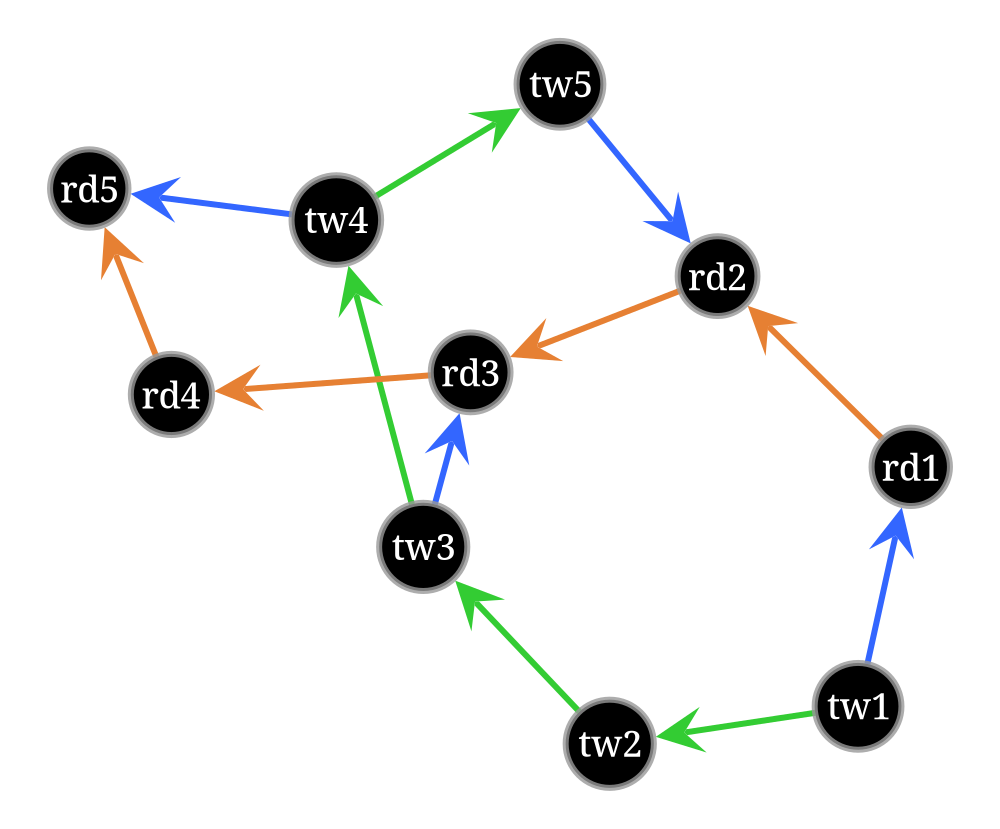

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f321ef3d9d0, at 0x7f32244f3d90>

In [26]:
import graph_tool.all as gt

# Create a directed graph with 10 vertices
g = gt.Graph(directed=True)
g.add_vertex(10)

# Vertex properties
label = g.new_vertex_property("string")
layer = g.new_vertex_property("string")

# Assign labels and layer types
twitter = ["tw1", "tw2", "tw3", "tw4", "tw5"]
reddit = ["rd1", "rd2", "rd3", "rd4", "rd5"]

for i, name in enumerate(twitter + reddit):
    label[g.vertex(i)] = name
    layer[g.vertex(i)] = "Twitter" if i < 5 else "Reddit"

g.vertex_properties["label"] = label
g.vertex_properties["layer"] = layer

# Edge properties
edge_type = g.new_edge_property("string")
edge_color = g.new_edge_property("vector<double>")

# Define edges
edges = [
    # Intra-Twitter
    (0, 1, "intra_twitter"),
    (1, 2, "intra_twitter"),
    (2, 3, "intra_twitter"),
    (3, 4, "intra_twitter"),

    # Intra-Reddit
    (5, 6, "intra_reddit"),
    (6, 7, "intra_reddit"),
    (7, 8, "intra_reddit"),
    (8, 9, "intra_reddit"),

    # Inter-layer
    (0, 5, "inter"),
    (2, 7, "inter"),
    (4, 6, "inter"),
    (3, 9, "inter")
]

# Add edges and assign types/colors
for u, v, etype in edges:
    e = g.add_edge(u, v)
    edge_type[e] = etype
    if etype == "intra_twitter":
        edge_color[e] = [0.2, 0.8, 0.2, 1]  # green
    elif etype == "intra_reddit":
        edge_color[e] = [0.9, 0.5, 0.2, 1]  # orange
    else:  # inter
        edge_color[e] = [0.2, 0.4, 1.0, 1]  # blue

# Register properties
g.edge_properties["type"] = edge_type
g.edge_properties["color"] = edge_color

# Draw the graph
pos = gt.sfdp_layout(g)
gt.graph_draw(
    g,
    pos=pos,
    vertex_text=label,
    vertex_fill_color=[0, 0, 0, 1],
    vertex_font_color=[1, 1, 1, 1],
    edge_color=edge_color,
    edge_marker="arrow",
    edge_arrow_size=10,
    vertex_size=30,
    output_size=(500, 500)
)


## Manipulate graphs

### Iterating over nodes and edges

### Iterating over neighbors 

### Advanced iteration 